In [1]:
from PIL import Image
import torchvision.transforms as T
import clip
import torch
from datasets.data_loader import TransVGDataset
from datasets import make_transforms

class args>
class TransVGDatasetSingleInference(TransVGDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Assume self.transform is already defined in TransVGDataset
        # If not, define a transform suitable for your model here
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def preprocess_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)  # Apply the transformations
        image = image.unsqueeze(0).to(self.device)  # Add batch dimension and send to device
        return image

    def preprocess_text(self, text_prompt):
        text_token = clip.tokenize([text_prompt]).to(self.device)  # Tokenize the text prompt
        return text_token

    def tokenize_data(self, image_path, text_prompt):
        image = self.preprocess_image(image_path)
        text_token = self.preprocess_text(text_prompt)
        # Perform inference here
        # For example: output = model(image, text_token)
        # Return the inference result
        return image, text_token


In [ ]:
# Initialize the modified dataset class for inference
# You'll need to provide the necessary arguments as required by the original TransVGDataset class
inference_dataset = TransVGDatasetSingleInference(data_root='path/to/data', transform=your_transform_here)

# Your own image path and text prompt
image_path = '/path/to/your/image.jpg'
text_prompt = 'A description of your image'

# Perform inference
output = inference_dataset.infer(image_path, text_prompt)

# Process the output as needed (e.g., display the prediction)


In [27]:
import datasets.transforms as T




def make_transforms(args, image_set, is_onestage=False):
    if is_onestage:
        normalize = Compose([
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return normalize

    imsize = args.imsize
    print(f'Using image size {imsize}')
    if image_set in ['train', 'train_pseudo']:
        scales = []
        if args.aug_scale:
            for i in range(7):
                scales.append(imsize - 32 * i)
        else:
            scales = [imsize]

        if args.aug_crop:
            crop_prob = 0.5
        else:
            crop_prob = 0.

        return T.Compose([
            T.RandomSelect(
                T.RandomResize(scales),
                T.Compose([
                    T.RandomResize([400, 500, 600], with_long_side=False),
                    T.RandomSizeCrop(384, 600),
                    T.RandomResize(scales),
                ]),
                p=crop_prob
            ),
            T.ColorJitter(0.4, 0.4, 0.4),
            T.GaussianBlur(aug_blur=args.aug_blur),
            # T.RandomHorizontalFlip(),  # We observe that RandomHorizontalFlip is harmful to the grounding task.
            T.ToTensor(),
            T.NormalizeAndPad(size=imsize, aug_translate=args.aug_translate)
        ])


    if image_set in ['val', 'test', 'testA', 'testB']:
        return T.Compose([
            T.RandomResize([imsize]),
            T.ToTensor(),
            T.NormalizeAndPad(size=imsize),
        ])

    raise ValueError(f'unknown {image_set}')



In [32]:
import cv2 
import torch 

class Args:
    def __init__(self) -> None:
        self.imsize = 244
def denormalize_bboxes(input_dict, original_width, original_height,imsize=640):
    """
    Adjusts bounding boxes from the processed (padded/translated) image back to the
    original image's coordinate system.
    
    Parameters:
    - input_dict: A dictionary containing the processed image's bounding boxes
      and possibly other data.
    - original_width: The width of the original image before processing.
    - original_height: The height of the original image before processing.
    
    The bounding boxes in input_dict are expected to be in normalized format
    (x_center, y_center, width, height) relative to the processed image's dimensions.
    """
    mean=[0.485, 0.456, 0.406] 
    std=[0.229, 0.224, 0.225]
    img = input_dict['img']
    #normalize image
    
    h, w = img.shape[1:]
    dw = imsize - w
    dh = imsize - h
    top = round(dh / 2.0 - 0.1)
    left = round(dw / 2.0 - 0.1)
    print(f"Top: {top}, Left: {left}, dw: {dw}, dh: {dh} , imsize: {imsize}, h: {h}, w: {w}")
    # Extract the bounding box in normalized format
    bbox = input_dict['box']  # Assuming bbox is (x_center, y_center, width, height) and normalized
    
    # Denormalize bbox coordinates
    x_center, y_center, width, height = bbox * torch.tensor([w, h, w, h], dtype=torch.float32)
     # Adjust for padding
    # Convert from (x_center, y_center, width, height) to (xmin, ymin, xmax, ymax)
    xmin = x_center - (width / 2)
    ymin = y_center - (height / 2)
    xmax = x_center + (width / 2)
    ymax = y_center + (height / 2)
    
    # Update input_dict with the adjusted bounding box
    input_dict['denormalized_box'] = torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32)
    #to list of ints 
    input_dict['denormalized_box'] = input_dict['denormalized_box'].int()
    #to list
    input_dict['denormalized_box'] = input_dict['denormalized_box'].tolist()
    #from x,y,w,h to x1,y1,x2,y2
    # input_dict['denormalized_box'] = [input_dict['denormalized_box'][0], input_dict['denormalized_box'][1], input_dict['denormalized_box'][0]+input_dict['denormalized_box'][2], input_dict['denormalized_box'][1]+input_dict['denormalized_box'][3]]
    return input_dict['denormalized_box']

image_path =  "/Users/yacineflici/Documents/master-vmi/s2/TER/referit/images/9739.jpg"
img =  cv2.imread(image_path)
real_box = [322, 303, 359, 372]
#gt_boxes[i] tensor([0.4990, 0.7948, 0.7479, 0.4062])
gt_boxes = torch.tensor([[0.8344, 0.7031, 0.0771, 0.1438]])
input_dict = {'box': gt_boxes[0], 'img': img}
tensored_gt = gt_boxes[0].tolist()
original_width = img.shape[1]
original_height = img.shape[0]

new_boxes = [tensored_gt[0] * original_width, tensored_gt[1] * original_height, tensored_gt[2] * original_width, tensored_gt[3] * original_height]
#to int 
new_boxes = [int(new_boxes[0]), int(new_boxes[1]), int(new_boxes[2]), int(new_boxes[3])]
#to x,y,x,y
new_boxes = [new_boxes[0], new_boxes[1], new_boxes[0]+new_boxes[2], new_boxes[1]+new_boxes[3]]
print(f"Real box: {real_box}")
print(f"New box: {new_boxes}")


Real box: [322, 303, 359, 372]
New box: [300, 337, 327, 406]


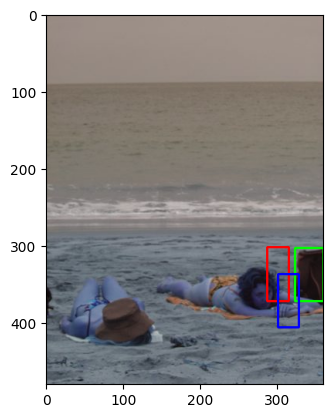

In [24]:
#draw boxes on image using cv2 

import cv2
import matplotlib.pyplot as plt
#inline image 
# Load the image
image_path =  "/Users/yacineflici/Documents/master-vmi/s2/TER/referit/images/9739.jpg"
img = cv2.imread(image_path)
# Draw the bounding box
x1, y1, x2, y2 = denormalized_box
cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
#second box 
x1, y1, x2, y2 = real_box
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#third 
x1, y1, x2, y2 = new_boxes
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(img)
plt.show()

In [35]:
#reshape image 
import datasets.transforms as T
from PIL import Image

img = Image.open(image_path)
input_dict = {'img': img, 'box': gt_boxes[0]}
#resize image
T.RandomResize([224])(input_dict)

{'img': <PIL.Image.Image image mode=RGB size=168x224 at 0x1579C2190>,
 'box': tensor([0.3894, 0.3281, 0.0360, 0.0671])}